In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def noising(betas, image, key, steps):
    noisy_images = []

    current_image = image
    for i in range(steps):
        key, subkey = jax.random.split(key)
        noise = jax.random.normal(subkey, shape=image.shape)
        current_image = jnp.sqrt(1-betas[i]) * current_image + jnp.sqrt(betas[i]) * noise
        noisy_images.append(current_image)
    return noisy_images

In [3]:
steps=100
betas = jnp.linspace(1e-4, 0.02, steps)
image = jnp.ones((64, 64, 3))
key=jax.random.PRNGKey(0)
noisy_images=noising(betas, image, key, steps)

In [4]:
def show_image(image, title=None):
    plt.imshow(jnp.clip(image, 0, 1))  # Clamp values to [0, 1] for display
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

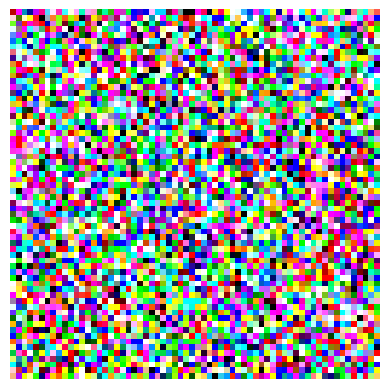

In [5]:
show_image(noisy_images[99])

In [6]:
import tensorflow_datasets as tfds
def load_cifar10(num_samples=10000):
    ds = tfds.load("cifar10", split="train", as_supervised=True)
    ds = ds.take(num_samples)

    images, labels = [], []
    for image, label in tfds.as_numpy(ds):
        images.append(np.array(image) / 255.0)  # Normalize
        labels.append(label)

    return jnp.array(images), jnp.array(labels)

# Create database
images_db, labels_db = load_cifar10()


In [7]:
dogcat_mask = (labels_db == 3) | (labels_db == 5)
dogcat_db=images_db[dogcat_mask]
dogcat_labels=labels_db[dogcat_mask]

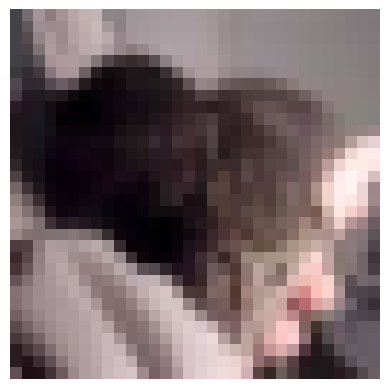

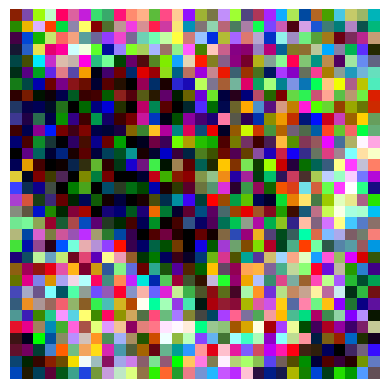

Array(3, dtype=int32)

In [41]:
show_image(dogcat_db[1])
key, subkey = jax.random.split(key)
noisy_images=noising(betas, dogcat_db[1], subkey, steps)
show_image(noisy_images[35])
dogcat_labels[1]

In [38]:
#creating noisydogcat images
from functools import partial
keys = jax.random.split(jax.random.PRNGKey(0), len(dogcat_db))

noisingthrehold=20

partial_noise = partial(noising, betas=betas, steps=steps)

#separate training and testing
dogcat_db_train=dogcat_db[:1600]
dogcat_db_test=dogcat_db[1600:]
noisydogcat_train=jax.vmap(partial_noise)(key=keys[:1600], image=dogcat_db_train)[:noisingthrehold]
noisydogcat_test=jax.vmap(partial_noise)(key=keys[1600:], image=dogcat_db_test)[:noisingthrehold]

#get labels
noisydogcat_train=jnp.concatenate(noisydogcat_train, axis=0)
noisylabels_train=jnp.tile(dogcat_labels[:1600], noisingthrehold)

In [10]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

In [13]:
#train classifier (noisy)
#Preprocess the image
proc_noisydogcat_train=noisydogcat_train.reshape(noisydogcat_train.shape[0],-1)
#proc_dogcat_test=dogcat_test.reshape(dogcat_test.shape[0],-1)
# Scale features
scaler = StandardScaler()
proc_noisydogcat_train = scaler.fit_transform(proc_noisydogcat_train)
#X_test_scaled = scaler.transform(flattened_dogcat_test)

In [ ]:

# Train SVM classifier (original)
clf = svm.SVC(kernel='rbf', random_state=42)
clf.fit(proc_noisydogcat_train, noisylabels_train)


In [12]:
#Train SVM classifier (original)
#Preprocess the image
proc_dogcat_train=dogcat_db_train.reshape(dogcat_db_train.shape[0],-1)
#proc_dogcat_test=dogcat_test.reshape(dogcat_test.shape[0],-1)
# Scale features
scaler = StandardScaler()
proc_dogcat_train = scaler.fit_transform(proc_dogcat_train)
#X_test_scaled = scaler.transform(flattened_dogcat_test)
# Train SVM classifier (original)
clf_ori = svm.SVC(kernel='rbf', random_state=42)
clf_ori.fit(proc_dogcat_train, dogcat_labels[:1600])

SVC(random_state=42)

In [36]:
# Predict & evaluate for each noise under noise threshold
#process the image

acc_ori=[]
acc_noisy=[]
for i in range(noisingthrehold):
  proc_noisydogcat_test=noisydogcat_test[i].reshape(noisydogcat_test[i].shape[0],-1)
  scaler = StandardScaler()
  proc_noisydogcat_test = scaler.fit_transform(proc_noisydogcat_test)

  #noisy classifier prediction
  #y_pred_noisy = clf.predict(proc_noisydogcat_test)
  #acc.append(accuracy_score(labels_test[1600:], y_pred_noisy))


  #original classifier prediction (no noise)
  y_pred_ori = clf_ori.predict(proc_noisydogcat_test)
  acc_ori.append(accuracy_score(dogcat_labels[1600:], y_pred_ori))
#print(f"Test accuracy: {acc:.4f}")

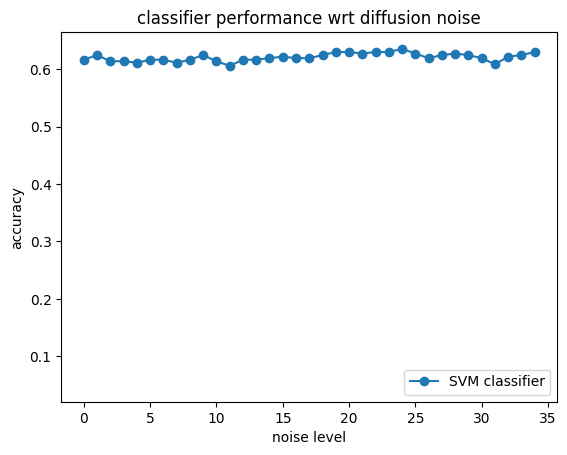

In [40]:
#show evaluation
x=list(range(len(acc_ori)))
plt.plot(x, acc_ori, label='SVM classifier', marker='o')
#plt.plot(x, acc_noisy, label='noisy classifier', marker='o')
plt.plot(0.05,0.05, color='white')

# Add labels and legend
plt.xlabel('noise level')
plt.ylabel('accuracy')
plt.title('classifier performance wrt diffusion noise')
plt.legend()
#plt.grid(True)

# Show plot
plt.show()

In [31]:
x

[0]

In [24]:
# Predict & evaluate
y_pred = clf.predict(X_test_scaled)
acc = accuracy_score(labels_test, y_pred)
print(f"Test accuracy: {acc:.4f}")

Test accuracy: 0.5519


In [14]:
augdogcat_train.shape

(1578, 32, 32, 3)

In [26]:
noisydogcat

AttributeError: 'list' object has no attribute 'shape'

In [41]:
dogcat_db[1600:].shape

(373, 32, 32, 3)

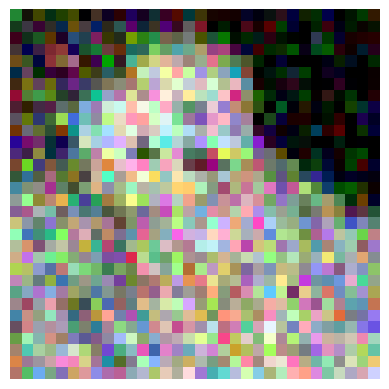

In [34]:
show_image(noisydogcat_test[15][30])